In [6]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl

import os
from collections import defaultdict

import io

In [7]:
def set_paramters (filepath):
    with open(filepath) as file:
        for line in file:
            if line.startswith("#m="):
                global m
                m = float(line.strip()[3:])
            elif line.startswith("#A="):
                global a
                a = int(line.strip()[3:])
            elif line.startswith("#H="):
                global h
                h = int(line.strip()[3:])
            elif line.startswith("#rH2="):
                global rh2
                rh2 = float(line.strip()[5:])
            elif line.startswith("#Rp2="):
                global rp2
                rp2 = float(line.strip()[5:])
            elif line.startswith("#RC2="):
                global rc2
                rc2 = float(line.strip()[5:])
            else:
                break



def set_parameters_manually (m_, a_, h_, rh_sqr_, rp_sqr_, rc_sqr_):
    global m
    m = m_
    
    global a
    a = a_
    
    global h
    h = h_

    global rh2
    rh2 = rh_sqr_

    global rp2
    rp2 = rp_sqr_

    global rc2
    rc2 = rc_sqr_



def files_with_same_parameters (directory):
    matching_files = list()
    for filename in os.listdir(directory):
        with open(directory+filename, 'r') as file:
            for line in file:
                if line.startswith("#m="):
                    if (m != float(line.strip()[3:])):
                        break
                elif line.startswith("#A="):
                    if (a != int(line.strip()[3:])):
                        break
                elif line.startswith("#H="):
                    if (h != int(line.strip()[3:])):
                        break
                elif line.startswith("#rH2="):
                    if (rh2 != float(line.strip()[5:])):
                        break
                elif line.startswith("#Rp2="):
                    if (rp2 != float(line.strip()[5:])):
                        break
                elif line.startswith("#RC2="):
                    if (rc2 != float(line.strip()[5:])):
                        break
                elif line.startswith("##"):
                    matching_files.append(directory+filename)
                    break
    return matching_files



def find_different_q_values (q_all):
    q_values = []
    for q in q_all[0]:
        if q not in q_values:
            q_values.append(q)
    
    return q_values



def find_differnt_delta_values (delta_all):
    delta_values = []
    for delta in delta_all[0]:
        if delta not in delta_values:
            delta_values.append(delta)
    
    return delta_values



def read_data_from_files (file_list):
    print(f"Reading from {len(file_list)} files")

    delta_all = []
    q_all = []
    a_real_all = []
    a_imag_all = []
    b_all = []
    hotspot_pos_all = []

    # Loop through each file in the directory
    for filename in file_list:
        delta_array = []
        q_array = []
        a_real_array = []
        a_imag_array = []
        b_array = []
        hotspot_pos_array = []
        hotspot_pos_entry = []
        line_is_hotspot_pos = False

        with open(filename, 'r') as file:
            # Read data from the file and store it in the dictionary
            for line in file:
                if line.startswith('#Nucleon') and not line_is_hotspot_pos:
                    line_is_hotspot_pos = True
                elif line_is_hotspot_pos:
                    if line.startswith('#Nucleon'):
                        hotspot_pos_array.append(hotspot_pos_entry)
                        hotspot_pos_entry = []
                    elif line.startswith('##'):
                        hotspot_pos_array.append(hotspot_pos_entry)
                        line_is_hotspot_pos = False
                        hotspot_pos_entry = []
                    else:
                        x1, x2 = map(str, line.strip().split(' '))
                        x1 = x1.replace('#', '')
                        hotspot_pos_entry.append( { 'x1':float(x1), 'x2':float(x2) } )

                elif (line == "\n"):
                    continue
                elif line.startswith("#"):
                    continue
                else:
                    delta, q, a_real, a_imag, b = map(float, line.strip().split(" "))

                    delta_array.append(delta)
                    q_array.append(q)
                    a_real_array.append(a_real)
                    a_imag_array.append(a_imag)
                    b_array.append(b)
        
        delta_all.append(delta_array)
        q_all.append(q_array)
        a_real_all.append(a_real_array)
        a_imag_all.append(a_imag_array)
        b_all.append(b_array)
        hotspot_pos_all.append(hotspot_pos_array)
    
    len_store = len(q_all[0])

    #checking if Q values are the same for all files
    for q_vals in q_all:
        if len(q_vals) != len_store:
            print("Some files do not have the same number of data points (Q)!")
            exit()

    for q_index in range( len(q_all[0]) ):
        q_store = q_all[0][q_index]
        for event_index in range( len(q_all) ):
            if q_store != q_all[event_index][q_index]:
                print("Q values are not the same for some of the files!")
                exit()

    for delta_vals in delta_all:
        if len(delta_vals) != len_store:
            print("Some files do not have the same number of data points (Delta)!")
            exit()

    for delta_index in range( len(delta_all[0]) ):
        delta_store = delta_all[0][delta_index]
        for event_index in range( len(delta_all) ):
            if delta_store != delta_all[event_index][delta_index]:
                print("Delta values are not the same for some of the files!")
                exit()

    all_dict = {
                'Delta':delta_all,
                'Q':q_all,
                'A_real':a_real_all,
                'A_imag':a_imag_all,
                'B':b_all,
                'Hotspot':hotspot_pos_all,
            }
    
    return all_dict



def calculate_cs (all_dict):
    cs_results = []

    q_values = find_different_q_values(all_dict['Q'])
    delta_values = find_differnt_delta_values(all_dict['Delta'])

    num_events = len(all_dict['Delta'])
    print(f"Data from {num_events} events")

    num_values = len(all_dict['Delta'][0])

    for q in q_values:
        t_values = []

        a_real_avg_of_sqrs_values = []
        a_imag_avg_of_sqrs_values = []

        a_real_sqr_of_avg_values = []
        a_imag_sqr_of_avg_values = []

        a_avg_of_sqrs_values = []
        a_sqr_of_avg_values = []
        b_avg_values = []
        inco_values = []

        a_real_avg_of_sqrs_err_values = []
        a_imag_avg_of_sqrs_err_values = []

        a_real_sqr_of_avg_err_values = []
        a_imag_sqr_of_avg_err_values = []

        a_avg_of_sqrs_err_values = []
        a_sqr_of_avg_err_values = []
        b_avg_err_values = []
        inco_err_values = []


        for delta in delta_values:
            a_real_avg_of_sqrs = 0.0
            a_imag_avg_of_sqrs = 0.0

            a_real_sqr_of_avg = 0.0
            a_imag_sqr_of_avg = 0.0

            b_avg = 0.0

            a_real_avg_of_sqrs_err = 0.0
            a_imag_avg_of_sqrs_err = 0.0

            a_real_sqr_of_avg_err = 0.0
            a_imag_sqr_of_avg_err = 0.0

            b_avg_err = 0.0

            t_values.append(delta*delta)

            # calculating the averages
            for value_index in range(num_values):
                for event_index in range(num_events):
                    if q==all_dict['Q'][event_index][value_index] and delta==all_dict['Delta'][event_index][value_index]:
                        a_real_avg_of_sqrs += np.square(all_dict['A_real'][event_index][value_index])/float(num_events)
                        a_imag_avg_of_sqrs += np.square(all_dict['A_imag'][event_index][value_index])/float(num_events)

                        a_real_sqr_of_avg += all_dict['A_real'][event_index][value_index]/float(num_events)
                        a_imag_sqr_of_avg += all_dict['A_imag'][event_index][value_index]/float(num_events)

                        b_avg += all_dict['B'][event_index][value_index]/float(num_events)

            a_real_sqr_of_avg *= a_real_sqr_of_avg
            a_imag_sqr_of_avg *= a_imag_sqr_of_avg

            # calculating the std devs
            for value_index in range(num_values):
                for event_index in range(num_events):
                    if q==all_dict['Q'][event_index][value_index] and delta==all_dict['Delta'][event_index][value_index]:
                        a_real_avg_of_sqrs_err += np.square( np.square(all_dict['A_real'][event_index][value_index])-a_real_avg_of_sqrs )
                        a_imag_avg_of_sqrs_err += np.square( np.square(all_dict['A_imag'][event_index][value_index])-a_imag_avg_of_sqrs )
                        
                        a_real_sqr_of_avg_err += np.square( np.square(all_dict['A_real'][event_index][value_index])-a_real_sqr_of_avg )
                        a_imag_sqr_of_avg_err += np.square( np.square(all_dict['A_imag'][event_index][value_index])-a_imag_sqr_of_avg )

                        b_avg_err += np.square(all_dict['B'][event_index][value_index]-b_avg)

            a_real_avg_of_sqrs_err = np.sqrt( a_real_avg_of_sqrs_err/float(num_events*num_events) )
            a_imag_avg_of_sqrs_err = np.sqrt( a_imag_avg_of_sqrs_err/float(num_events*num_events) )
            
            a_real_sqr_of_avg_err = np.sqrt( a_real_sqr_of_avg_err/float(num_events*num_events) )
            a_imag_sqr_of_avg_err = np.sqrt( a_imag_sqr_of_avg_err/float(num_events*num_events) )

            b_avg_err= np.sqrt( b_avg_err/float(num_events*num_events) )

            # saving the calculated values to lists
            a_real_avg_of_sqrs_values.append(a_real_avg_of_sqrs)
            a_imag_avg_of_sqrs_values.append(a_imag_avg_of_sqrs)

            a_real_sqr_of_avg_values.append(a_real_sqr_of_avg)
            a_imag_sqr_of_avg_values.append(a_imag_sqr_of_avg)

            a_real_avg_of_sqrs_err_values.append(a_real_avg_of_sqrs_err)
            a_imag_avg_of_sqrs_err_values.append(a_imag_avg_of_sqrs_err)

            a_real_sqr_of_avg_err_values.append(a_real_sqr_of_avg_err)
            a_imag_sqr_of_avg_err_values.append(a_imag_sqr_of_avg_err)
            
            # the important values
            a_avg_of_sqrs = a_real_avg_of_sqrs+a_imag_avg_of_sqrs
            a_sqr_of_avg = a_real_sqr_of_avg+a_imag_sqr_of_avg

            a_avg_of_sqrs_err = a_real_avg_of_sqrs_err+a_imag_avg_of_sqrs_err
            a_sqr_of_avg_err = a_real_sqr_of_avg_err+a_imag_sqr_of_avg_err

            # saving the important values
            a_avg_of_sqrs_values.append(a_avg_of_sqrs)
            a_sqr_of_avg_values.append(a_sqr_of_avg)
            b_avg_values.append(b_avg)
            inco_values.append( b_avg + (a_avg_of_sqrs-a_sqr_of_avg)*2.5 )
            
            a_avg_of_sqrs_err_values.append(a_avg_of_sqrs_err)
            a_sqr_of_avg_err_values.append(a_sqr_of_avg_err)
            b_avg_err_values.append(b_avg_err)
            inco_err_values.append( np.sqrt( np.square(b_avg_err)+np.square(a_avg_of_sqrs_err)+np.square(a_sqr_of_avg_err) ) )

        # saving the lists in the dictionary
        cs_results_single_Q = {
            't':t_values,

            '<A^2>':a_avg_of_sqrs_values,
            '<A>^2':a_sqr_of_avg_values,
            '<B>':b_avg_values,

            '<A^2>Err':a_avg_of_sqrs_err_values,
            '<A>^2Err':a_sqr_of_avg_err_values,
            '<B>Err':b_avg_err_values,

            'Co':a_sqr_of_avg_values,
            'Inco':inco_values,

            'CoErr':a_avg_of_sqrs_err_values,
            'IncoErr':inco_err_values,
        }

        cs_results.append(cs_results_single_Q)
    
    return cs_results



def output_cs_results (cs_results, filepath):
    with open(filepath, 'w') as file:
        file.write(f"#m={m}\n"
                    f"#A={a}\n"
                    f"#rH2={rh2}\n"
                    f"#Rp2={rp2}\n"
                    f"#RC2={rc2}\n")
        file.write("#1t, 2Co, 3CoErr, 4Inco, 5IncoErr, 6Color, 7ColorErr, 8Hotspot, 9HotspotErr\n")
        for i in range( len(cs_results[0]['t']) ):
            file.write(f"{cs_results[0]['t'][i]} {cs_results[0]['Co'][i]} {cs_results[0]['CoErr'][i]} {cs_results[0]['Inco'][i]} {cs_results[0]['IncoErr'][i]} {cs_results[0]['<B>'][i]} {cs_results[0]['<B>Err'][i]} {cs_results[0]['<A^2>'][i]-cs_results[0]['<A>^2'][i]} {np.sqrt( np.square(cs_results[0]['<A^2>Err'][i])+np.square(cs_results[0]['<A>^2Err'][i]) )}")
            file.write("\n")



def output_all_runs (all_dict, filepath): # TODO make this work correctly for runs with different Q values
    num_events = len(all_dict['Delta'])
    num_values = len(all_dict['Delta'][0])

    with open(filepath, 'w') as file:
        for event_index in range(num_events):
            for value_index in range(num_values):
                file.write(f"{np.square(all_dict['Delta'][event_index][value_index])} {all_dict['A_real'][event_index][value_index]} {all_dict['A_imag'][event_index][value_index]} {all_dict['B'][event_index][value_index]}")
                file.write("\n")
            file.write("\n")
            file.write("\n")

In [8]:
# Define the directory where your files are located
dense_or_dilute = 'dense'
additional_folder = 'default-delta-single-q'
directory = '../Data/raw/' + dense_or_dilute + '/' #+ additional_folder + '/'

#set_paramters("../Data/3651184495_Amplitude.dat")
set_parameters_manually(0.22, 1, 3, 0.7, 3.3, 2.9)
file_list = files_with_same_parameters(directory)
print(file_list)

all_dict = read_data_from_files(file_list)
hotspot_pos = all_dict['Hotspot']
cs_results = calculate_cs(all_dict)
output_all_runs(all_dict, '../Data/dsigmadt_'+dense_or_dilute+'_sampled_all_runs.dat')

print("Hotspot positions")
for event_index in range( len(hotspot_pos) ):
    print( all_dict['Hotspot'][event_index] )

filepath = '../Data/dsigmadt_'+dense_or_dilute+'_sampled'

output_cs_results(cs_results, filepath)

['../Data/raw/dense/850375508_Amplitude.dat', '../Data/raw/dense/3167739308_Amplitude.dat', '../Data/raw/dense/2834343912_Amplitude.dat', '../Data/raw/dense/2194814112_Amplitude.dat', '../Data/raw/dense/3148197440_Amplitude.dat', '../Data/raw/dense/874569212_Amplitude.dat', '../Data/raw/dense/683633108_Amplitude.dat', '../Data/raw/dense/412533972_Amplitude.dat', '../Data/raw/dense/2470829576_Amplitude.dat', '../Data/raw/dense/2557113792_Amplitude.dat', '../Data/raw/dense/4189720536_Amplitude.dat', '../Data/raw/dense/4256166152_Amplitude.dat', '../Data/raw/dense/653417620_Amplitude.dat', '../Data/raw/dense/2271316312_Amplitude.dat', '../Data/raw/dense/1297436704_Amplitude.dat', '../Data/raw/dense/925231956_Amplitude.dat', '../Data/raw/dense/1641991483_Amplitude.dat', '../Data/raw/dense/3751657704_Amplitude.dat', '../Data/raw/dense/3419463100_Amplitude.dat', '../Data/raw/dense/1056553056_Amplitude.dat', '../Data/raw/dense/206356424_Amplitude.dat', '../Data/raw/dense/2506618980_Amplitude.

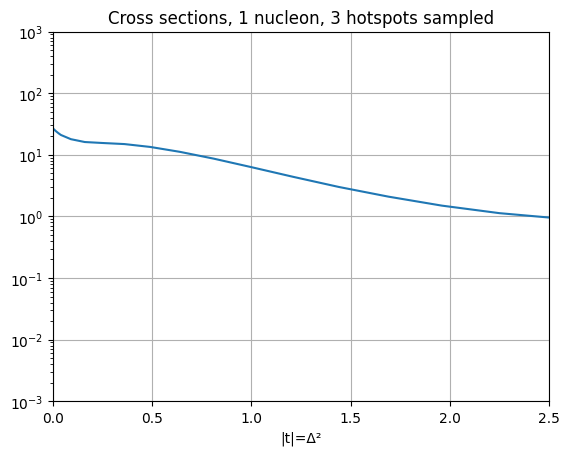

In [9]:
plt.title("Cross sections, 1 nucleon, 3 hotspots sampled")
plt.xlabel('|t|=Δ²')
plt.grid()
plt.xlim(0, 2.5)
plt.yscale('log')
plt.ylim(1.0e-3, 1.0e3)
plt.errorbar(cs_results[0]['t'], cs_results[0]['Inco'])
#plt.semilogy(cs_results[0][0], cs_results[0][3])
plt.show()

In [10]:
print("finished")

finished
